# Data Lab 4

Predicting climate 3-month averages (precipitation, near-surface temperature) from the ENSO state

In [2]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Indonesia precipitation example

Predicting JJA Indonesia precipitation from ENSO state.

The conditional distribution aka "forecast distribution" 

$$ p(y | x) $$

- $y$ is Indonesia precipitation
- $x$ 
    - categorical: cool, neutral, warm Nino 3.4 based on terciles
    - Nino 3.4 value

Forecast formats
- single number
- Prediction interval
- Prob. of above, middle, below rainfall categories

Training data: 1979 - 2019

Test data: 2020


## 1. Read data

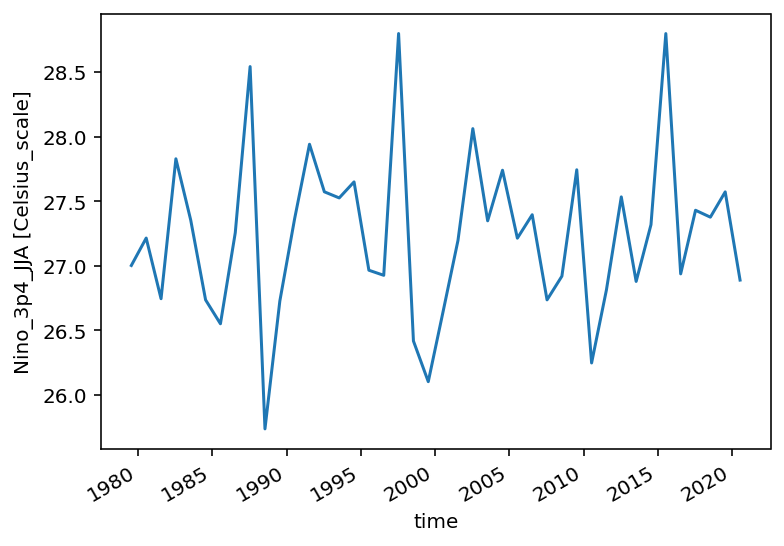

In [3]:
# Read JJA Nino 3.4
n34_JJA_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_JJA/dods'
n34_JJA_ds = xr.open_dataset(n34_JJA_url)
n34_JJA = n34_JJA_ds.n34_JJA
n34_JJA.plot();

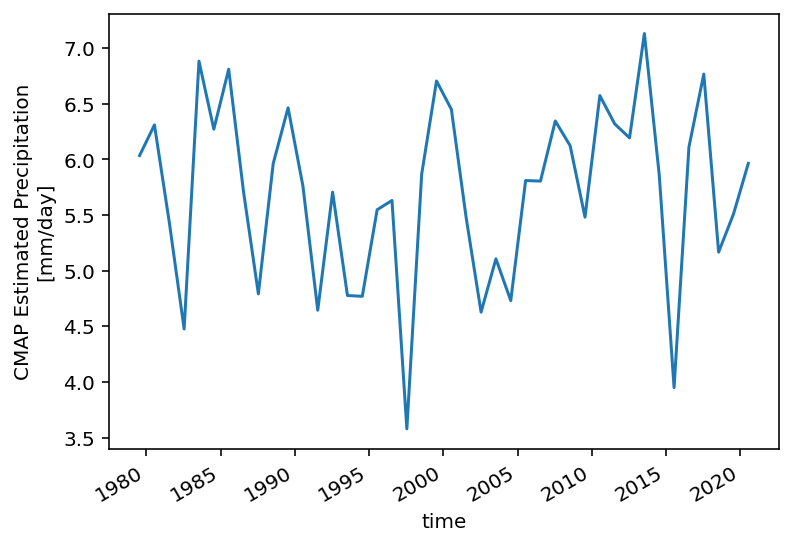

In [4]:
# Read Indonesia region rainfall
indo_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.indonesia_prcp_JJA/dods'
indo_ds = xr.open_dataset(indo_url)
prcp_indo = indo_ds.indonesia_prcp_JJA
prcp_indo.plot();

### 1.1 Withhold the final value (this year)

In [135]:
# Develop our prediction on all the values up to this year and then predict this year's value from xp
x = n34_JJA[0:-1].values
xp = n34_JJA[-1].values # this year
y = indo_ds.indonesia_prcp_JJA[:-1].values
yp = indo_ds.indonesia_prcp_JJA[-1].values

### 1.2 Define Nino 3.4 and precipitation terciles

In [6]:
# Define warm and cool ENSO categories
xm = x.mean()
xa = x - xm

thresholds = np.quantile(xa, np.array([1./3., 2./3.]))
t_nina = xa <= thresholds[0]
t_nino = xa >= thresholds[1]
t_neut = ~(t_nina | t_nino)

y_thresholds = np.quantile(y, np.array([1./3., 2./3.]))

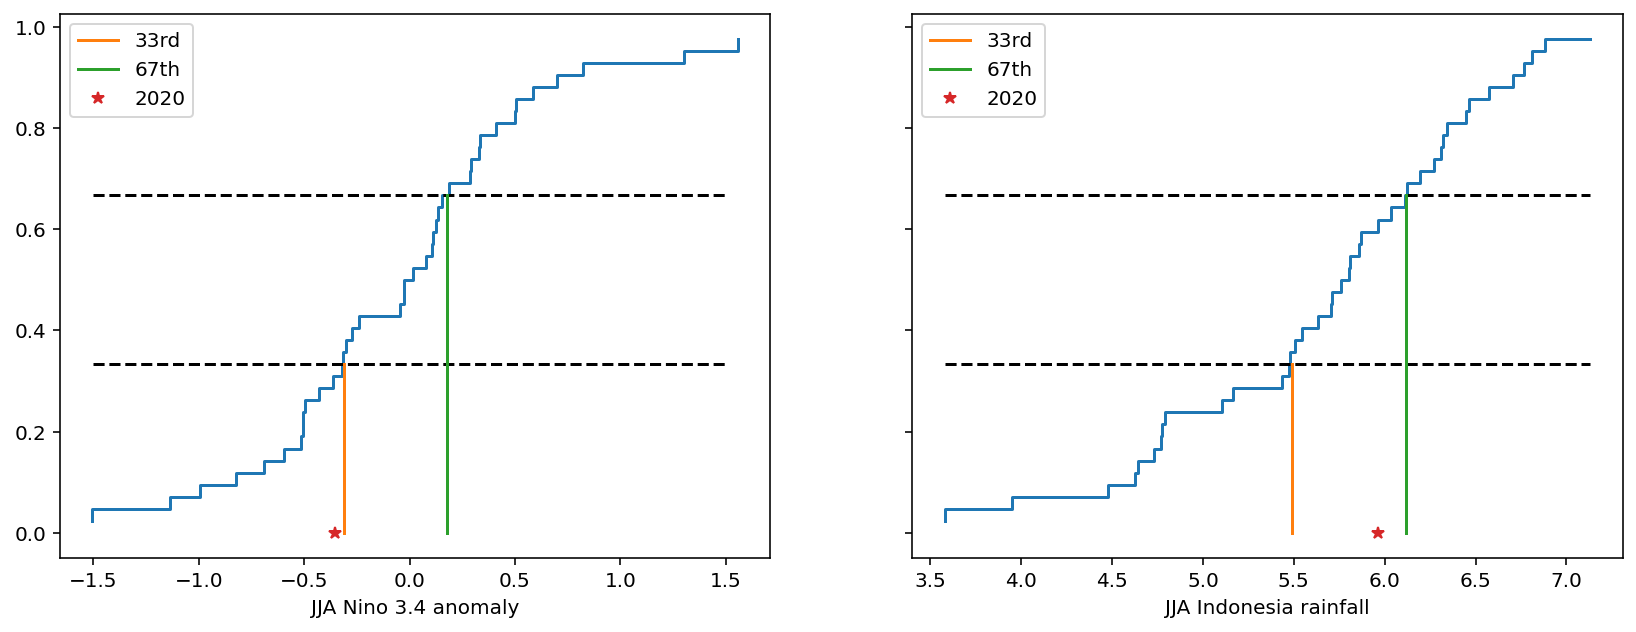

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14,5), sharey=True)

ax = axs[0]
ax.step(np.sort(xa), np.arange(1,41 + 1)/(41 + 1))
ax.plot(np.array([-1.5,1.5]), 1./3.*np.array([1,1]), 'k--')
ax.plot(np.array([-1.5,1.5]), 2./3.*np.array([1,1]), 'k--')
ax.plot(thresholds[0]*np.array([1, 1]), np.array([0, 1./3.]), label = '33rd')
ax.plot(thresholds[1]*np.array([1, 1]), np.array([0, 2./3.]), label = '67th')
ax.plot(xp - xm, 0, '*', label = '2020')
ax.set_xlabel('JJA Nino 3.4 anomaly');
ax.legend()

ax = axs[1]
ax.step(np.sort(y), np.arange(1,41 + 1)/(41 + 1))
x_range = np.array([y.min(),y.max()])
ax.plot(x_range, 1./3.*np.array([1,1]), 'k--')
ax.plot(x_range, 2./3.*np.array([1,1]), 'k--')
ax.plot(y_thresholds[0]*np.array([1, 1]), np.array([0, 1./3.]), label = '33rd')
ax.plot(y_thresholds[1]*np.array([1, 1]), np.array([0, 2./3.]), label = '67th')
ax.plot(yp, 0, '*', label = '2020')
ax.set_xlabel('JJA Indonesia rainfall');
ax.legend();

### 1.3 Make forecasts based on the JJA Nino 3.4 category

In [8]:
# Point estimate
y_forecast = np.mean(y[t_nina])
print('Forecast total = {:4.2f} mm/day'.format(y_forecast))
print('Forecast anomaly = {:4.2f} mm/day'.format(y_forecast - y.mean()))

Forecast total = 6.29 mm/day
Forecast anomaly = 0.59 mm/day


In [9]:
# Prediction interval
pi_80 = np.quantile(y[t_nina], [0.10, 0.90])
print('80% of the time during La Nina, JJA rainfall totals have been in the range', pi_80)
print('80% of the time during La Nina, JJA rainfall anomalies have been in the range', pi_80 - y.mean())

80% of the time during La Nina, JJA rainfall totals have been in the range [5.70192914 6.77854986]
80% of the time during La Nina, JJA rainfall anomalies have been in the range [0.00279527 1.07941599]


In [10]:
# Probability forecasts
P_above = np.mean( y[t_nina] > y_thresholds[1])
P_below = np.mean( y[t_nina] < y_thresholds[0])

print('Probability of prcp in the above category {:.1f}%'.format(100*P_above))
print('Probability of prcp in the neutral category {:.1f}%'.format(100*(1 - P_above - P_below)))
print('Probability of prcp in the below category {:.1f}%'.format(100*P_below))

Probability of prcp in the above category 71.4%
Probability of prcp in the neutral category 21.4%
Probability of prcp in the below category 7.1%


### 2. $K$-nearest neighbors: Predict rainfall based on the *value* of JJA Nino 3.4.

We cannot sample from $p(y|x)$ because

In [11]:
np.sum(x == xp)

0

But we can sample from $p(y|X \text{ is close to } x)$. We'd have to define close and that might depend on the value of $x$.

Alternatively we can use the $K$ data closest to $x$. What value should we choose for $K$? Not too big and not too small. $K=10$?

In [27]:
K = 10
knn = np.argsort( (x - xp)**2)
knn = knn[:K]
knn

array([34, 29, 17, 37, 32, 16,  0,  2, 28,  5])

### 2.1 Make forecasts 

In [14]:
# Point estimate
y_forecast = np.mean(y[knn])
print('Forecast total = {:4.2f} mm/day'.format(y_forecast))
print('Forecast anomaly = {:4.2f} mm/day'.format(y_forecast - y.mean()))

Forecast total = 6.09 mm/day
Forecast anomaly = 0.40 mm/day


In [15]:
# Prediction interval
pi_80 = np.quantile(y[knn], [0.10, 0.90])
print('80% of the JJA rainfall totals were in the range', pi_80)
print('80% of the JJA rainfall anomalies were in the range', pi_80 - y.mean())

80% of the JJA rainfall totals were in the range [5.53616681 6.42385831]
80% of the JJA rainfall anomalies were in the range [-0.16296706  0.72472444]


In [16]:
# Probability forecasts
P_above = np.mean( y[knn] > y_thresholds[1])
P_below = np.mean( y[knn] < y_thresholds[0])

print('Probability of prcp in the above category {:4.1f}%'.format(100*P_above))
print('Probability of prcp in the neutral category {:4.1f}%'.format(100*(1 - P_above - P_below)))
print('Probability of prcp in the below category {:4.1f}%'.format(100*P_below))

Probability of prcp in the above category 50.0%
Probability of prcp in the neutral category 40.0%
Probability of prcp in the below category 10.0%


Need an objective way of choosing $K$. Cross-validation is one approach. https://en.wikipedia.org/wiki/Cross-validation_(statistics)

KNN is based on $E[y|x]$ being a constant in a neighborhood of $x$.

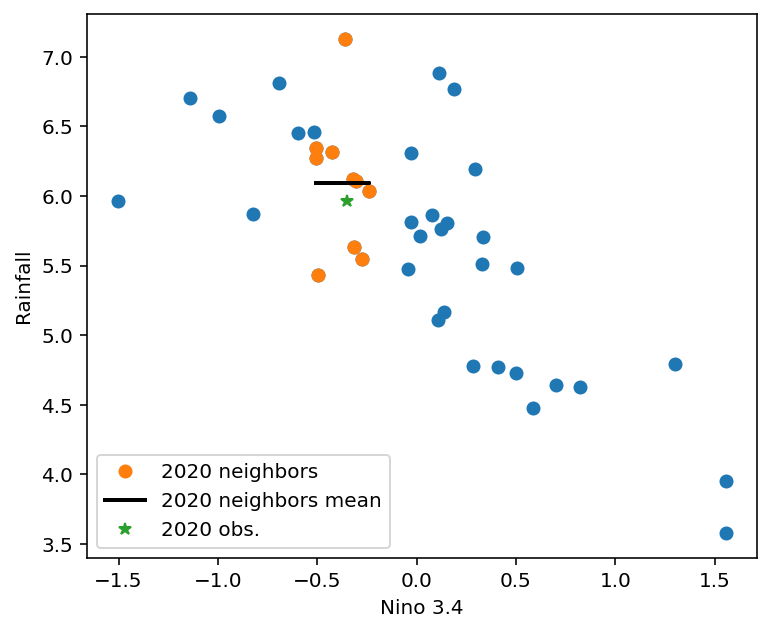

In [17]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(xa, y, 'o');
ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Rainfall');

ax.plot(xa[knn], y[knn],'o', label='2020 neighbors')
ax.plot(xa[knn], y[knn].mean() + np.zeros_like(y[knn]), 'k', linewidth=2, label='2020 neighbors mean')
ax.plot(xp - xm, yp, '*', label = '2020 obs.')

ax.legend();

### 3. Linear regression: Predict rainfall based on the *value* of JJA Nino 3.4.

Linear regression takes $ E[ y | x ]$ to be a linear function of $x$ everywhere:

$$ E(\text{rainfall } | \text{ Nino 3.4} = x ) = ax + b $$

Estimate $a$ and $b$ by least squares. Make a forecast (single number)

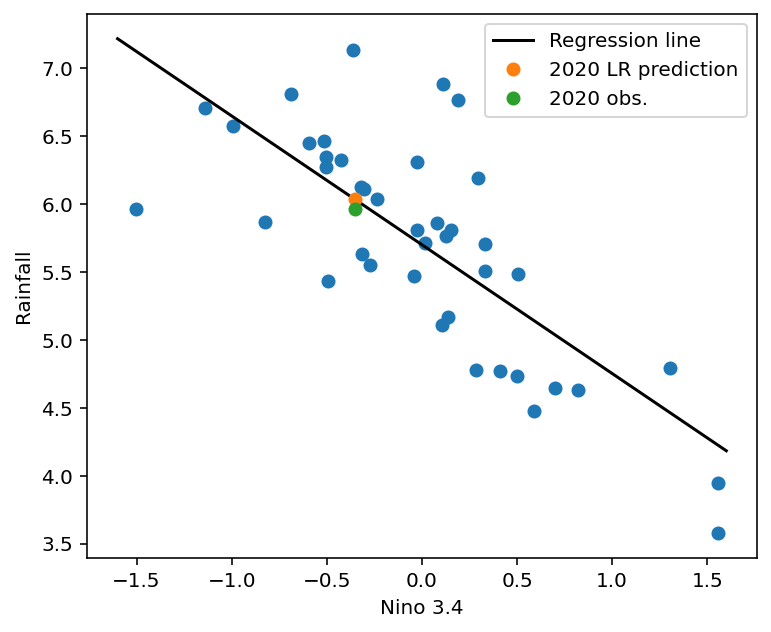

In [16]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(xa, y, 'o');
ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Rainfall');

from numpy.linalg import inv

Nx = len(xa)
X = np.empty((Nx,2))
X[:,0] = xa #<-------------------------------------------compare to below
X[:,1] = 1
beta = inv(X.T@X)@X.T@y
yhat = X@beta

y_forecast_LR = beta[0]*(xp -xm) + beta[1] 

x_line = np.linspace(-1.6, 1.6)
ax.plot(x_line, beta[0]*x_line + beta[1], 'k', label = 'Regression line');
ax.plot(xp - xm, y_forecast_LR, 'o', label = '2020 LR prediction')
ax.plot(xp - xm, yp, 'o', label = '2020 obs.')

ax.legend();

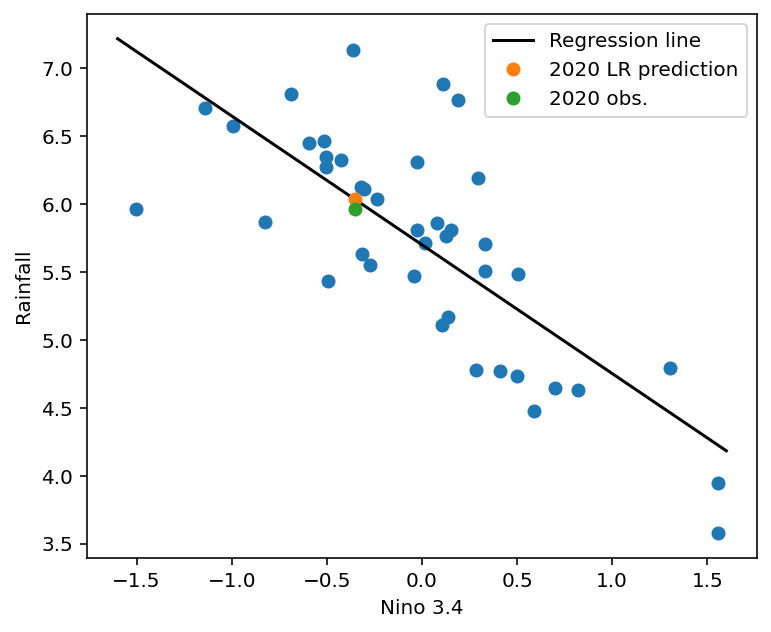

In [17]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(xa, y, 'o');
ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Rainfall');

from numpy.linalg import inv

Nx = len(xa)
X = np.empty((Nx,2))
X[:,0] = x #<-------------------------------------------compare to above
X[:,1] = 1
beta = inv(X.T@X)@X.T@y
yhat = X@beta

y_forecast_LR = beta[0]*(xp) + beta[1] 

x_line = np.linspace(-1.6, 1.6)
ax.plot(x_line, beta[0]*(x_line + xm) + beta[1], 'k', label = 'Regression line');
ax.plot(xp - xm, y_forecast_LR, 'o', label = '2020 LR prediction')
ax.plot(xp - xm, yp, 'o', label = '2020 obs.')

ax.legend();

## Exercises

1. (10 points) Show that the function $g(x)$ that minimizes $E[ (Y - g(x))^2 | X = x]$ is $g(x) = E[Y | X=x]$.  
HINT: As a warm-up, first show that the constant $c$ that minimizes $E[(y-c)^2]$ is $c = E[y]$ without using calculus.  
Look at the terms that come out of $E[(y-\mu_Y + \mu_Y - c)^2]$.

    **Part I**  
     $E[(y-c)^2] = E[(y-\mu_Y + \mu_Y - c)^2] = E[(y-\mu_Y)^2+(\mu_Y - c)^2+2(y-\mu_Y)(\mu_Y - c)]$  
     $= E[(y-\mu_Y)^2]+E[(\mu_Y - c)^2]+2E[(y-\mu_Y)(\mu_Y - c)]$   
       
     $E[y]= \mu_Y$, so $2E[(y-\mu_Y)(\mu_Y - c)] = 2(E[y]-\mu_Y)(\mu_Y - c)] = 2(0)(\mu_Y - c)]= 0$ (This works because we treat $\mu_Y$ and c as constants.)  
     $(\mu_Y - c)^2 \geq 0$ from properties of even exponents,   
     so $E[(y-\mu_Y)^2]$ and $E[(\mu_Y - c)^2] \geq 0$ from non-negativity preservation of integrals  
     $E[(y-\mu_Y)^2]$ does not depend on c.  
     When $c = E[y]$, $E[(\mu_Y - c)^2] = 0$, which is the minimum value for the left side as $E[(\mu_Y - c)^2] \geq 0$.
     Thus the total minimum is with $c = E[y]$
     
     **Part II** 
  
  For any fixed x in g(x), we can treat $E[Y | X=x]$ as a constant. ($Y | X=x$ is a random variable, so its expectation is a number.)  
  $E[ (Y - g(x))^2 | X = x] = E[ (Y - E[Y] + E[Y] - g(x))^2 | X = x]$  
  $= E[(Y - E[Y])^2| X = x] + E[(E[Y]-g(x))^2 | X = x] + E[(Y - E[Y])(E[Y]-g(x))| X = x]$  
    
  As above, treat the conditional $E[Y]$ and $g(x)$ as constants for a given x, so $E[(Y - E[Y])(E[Y]-g(x))| X = x] = (E[Y| X = x] - E[Y|X = x])(E[Y|X = x]-g(x)) = 0$
  
  Just as outlined in Part I, the leftmost term does not depend on g(x), and the rightmost term must $\geq 0$ with the term equaling 0 for a given x when $g(x) = E[Y | X=x]$.  
  So for any fixed x, $g(x)=E[Y | X=x]$ leads to the minimum value for the expression. The function $g(x)$ just then becomes the mapping of each fixed x to its respective fixed $g(x)$.

2. (10 points) Suppose that $\hat{\mu}_{Y|x}$ is the average of $N$ independent samples from $p(y|x)$.  
Show that $E[ Y - \hat{\mu}_{Y|x} | X = x] = 0$ and that
$$ E[ (Y - \hat{\mu}_{Y|x})^2 | X = x] = \sigma_{Y|x}^2 \left(1 + \frac{1}{N} \right) \,.$$  
HINT What is the variance of the sample mean?
Forecast error is due to randomness and error in the estimate of the conditional mean.

    **Part I:**
   $E[ Y - \hat{\mu}_{Y|x} | X = x] = E[ Y | X = x] - E [\hat{\mu}_{Y|x} | X = x] = E[ Y | X = x] - E[ \mu_{Y|x} ] = 0$  
   as the expectation of the sample mean is the population mean (given the same conditional values), which in this case is the same as the expectation.
   
    **Part II:**  
   $var(\hat{\mu}_{Y|x}) = E[(\hat{\mu}_{Y|x} - E[\hat{\mu}_{Y|x}])^2] = E[(\hat{\mu}_{Y|x} - \mu_{Y|x})^2]$  
   also, $var(\hat{\mu}_{Y|x}) = \frac{\sigma_{Y|x}^2}{N}$  
   $ E[ (Y - \hat{\mu}_{Y|x})^2 | X = x] = E[ (Y - \mu_{Y|x} + \mu_{Y|x} - \hat{\mu}_{Y|x})^2 | X = x]$  
   $= E[(Y - \mu_{Y|x})^2| X = x] + E[(\mu_{Y|x} - \hat{\mu}_{Y|x})^2)| X = x] + 2E[(Y - \mu_{Y|x})(\mu_{Y|x} - \hat{\mu}_{Y|x})| X = x]$  
   which, using equalities above and definition of variance, $= {\sigma_{Y|x}^2} + {\sigma_{Y|x}^2}\left(\frac{1}{N} \right) - 2E[(Y - \mu_{Y|x})(\hat{\mu}_{Y|x}-\mu_{Y|x})| X = x]$  
   $ = \sigma_{Y|x}^2 \left(1 + \frac{1}{N} \right) + cov (Y,\hat{\mu}_{Y|x}) = \sigma_{Y|x}^2 \left(1 + \frac{1}{N} \right)$
   Because Y and its sample mean are independent. The distribution of the mean depends on the samples from the distribution function, not from the values of Y that occur themselves.
 

3. (10 points) Compute a 95% confidence interval for the mean of JJA Indonesian rainfall during cool and warm conditions 1979-2019. 
(Reminder how here https://en.wikipedia.org/wiki/Student%27s_t-distribution#How_Student's_distribution_arises_from_sampling)
Add it to the code below to produce the figure. 
<div>
<img src="images/Indonesia_JJA_rainfall_Nino3p4.png" width="600"/>
</div>

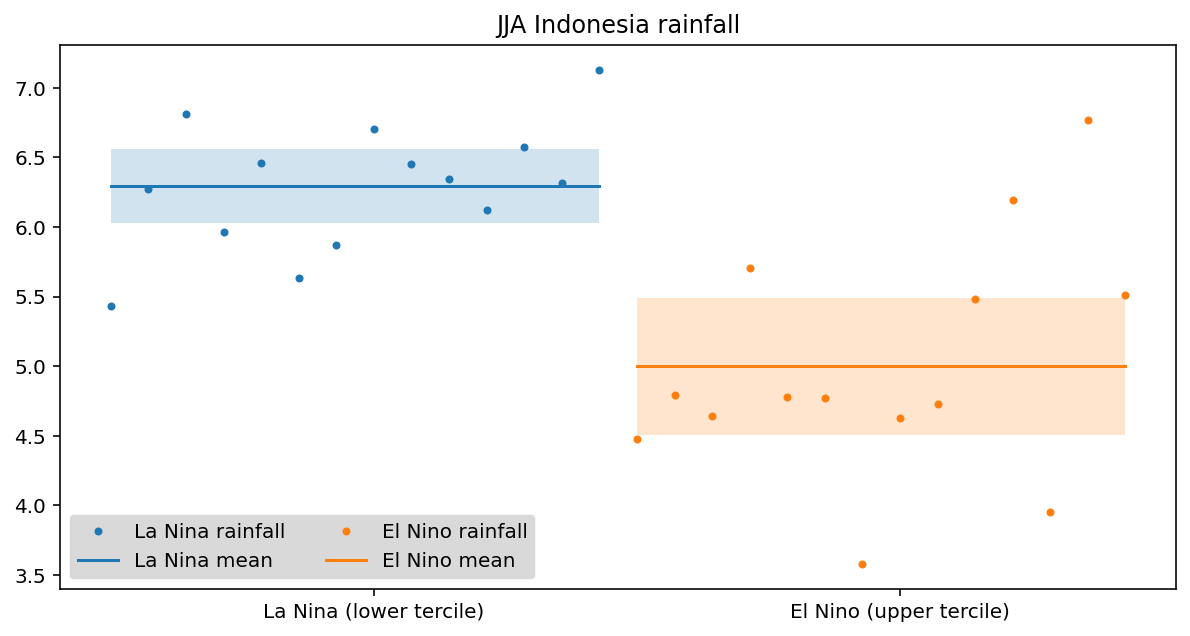

In [58]:
ci = np.nan

N1 = np.count_nonzero(t_nina)
N2 = np.count_nonzero(t_nino)
s1 = np.arange(0,N1)
s2 = np.arange(0,N2)

fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(s1, y[t_nina], '.', label = 'La Nina rainfall')
ax.plot(s1, y[t_nina].mean() + 0.0*s1, color=colors[0], label = 'La Nina mean')
ci = stats.t.ppf(1 - 0.05/2, df = N1-1)*np.sqrt(y[t_nina].var()/(N1-1))
ax.fill_between(s1, y[t_nina].mean() - ci + 0.0*s1, y[t_nina].mean() + ci + 0.0*s1, alpha = 0.2)

ax.plot(s2 + N1, y[t_nino], '.', label = 'El Nino rainfall')
ax.plot(s2 + N1, y[t_nino].mean() + 0.0*s2, color=colors[1], label = 'El Nino mean')
ci = stats.t.ppf(1 - 0.05/2, df = N2-1)*np.sqrt(y[t_nino].var()/(N2-1))
ax.fill_between(s2 + N1, y[t_nino].mean() - ci + 0.0*s2, y[t_nino].mean() + ci + 0.0*s2, alpha = 0.2)
ax.set_xticks([])

ax.legend(ncol = 2, framealpha = 0.15, facecolor = 'k', loc = 'lower left');
ax.set_title('JJA Indonesia rainfall');
plt.xticks([N1/2, 3*N2/2],['La Nina (lower tercile)', 'El Nino (upper tercile)']);
# Shading is CI for mean

4. (10 points) Choose $K$ in K-nearest neighbors by finding the value of $K$ whose leave-one-out cross-validated (CV) mean-squared error (MSE) is smallest. Below is starter code.
    - Add comments explaining what the code does. 
    - The 2D array `y_hat` contains forecasts with each column being a different year and each row using a different value of $K$.
    - Compute the error by subtracting $y$. Broadcasting is your friend.
    - Square and average over years to get the mean squared error as function of $K$.  
    - Plot the MSE as a function of $K$.
    
   <div>
   <img src="images/Indonesia_JJA_rainfall_Nino3p4_KNN_CV.png" width="400"/>
   </div>
    
    (The interval is a so-called 1$\sigma$ interval.)  
    MSE = mean(squared error)  
    $\sigma$ = std(squared error)/sqrt(sample size)
    

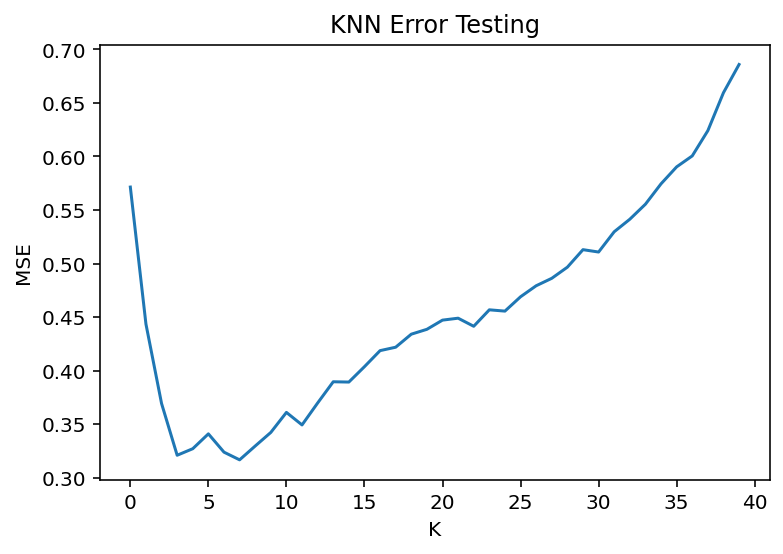

In [161]:
kmax = len(x) - 1
y_hat = np.empty((kmax, len(x)))
for ii in range(0, len(x)):#this loop isolates all of the remaining data points to test a given one
    leave_1_out = list(range(0, len(x)))
    leave_1_out.remove(ii)
    x1 = x[leave_1_out]
    y1 = y[leave_1_out]
    knn1 = np.argsort( (x1 - x[ii])**2)#sorts the data points by least sqared error, keeping track of the orders of each cardinality
    for k in range(1,kmax + 1):
        knn0 = knn1[:k]#picks out the kth nearest neighbors
        y_hat[k - 1, ii] = y1[knn0].mean()
y_error = np.zeros(np.shape (y_hat))
y_error_squared = np.zeros(np.shape (y_hat))
for jj in range (0, len(x)):
    for kk in range (0, kmax):
        y_error[kk, jj] = y_hat[kk,jj]-y[jj]
        y_error_squared[kk, jj] = y_error[kk, jj]**2
mse = np.mean(y_error_squared, axis = 1)
fig, ax = plt.subplots()
ax.plot(range(0, kmax), mse)
ax.set_xlabel('K')
ax.set_ylabel('MSE');
ax.set_title('KNN Error Testing');


5. (30 points) Look at the Oceanic Nino Index (ONI) values here https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
    - Which winters since 2010 had cool ONI conditions?  
        **The winters ending in 2011, 2012, 2018**
    - Find the NOAA winter precipitation outlooks for those years and include them below. Here is the one for the winter of 2017-2018
     <div>
      <img src="http://2.bp.blogspot.com/_oy2DMM6iwUU/TMCFsp7BvHI/AAAAAAAAB1s/S3X2iffrjIc/s1600/cpc.winteroutlookprecip2_20102.jpg" width="400"/>
     </div>
     <div>
      <img src="https://unofficialnetworks.com/wp-content/uploads/sites/88/2011/10/noaa1.png?resize=1024,576" width="400"/>
     </div>
     <div>
      <img src="https://www.climate.gov/sites/default/files/PrecipitationOutlook_Winter2017_620.png" width="400"/>
      </div>
    - Use the code below to read the Aug Nino 3.4 values from 1979 through 2020.
        - Find the 10 years with Aug Nino 3.4 values closest to that of 2020.
    - Use the code below to read the Dec-Feb (DJF) North America precipitation data for Dec 1979 - Feb 1980 though Dec 2019 - Feb 2020 (last winter). (The time coordinate of the precipitaion is the middle month (Jan) of the 3-month period.)
     - Use KNN with $K=10$ to
         - forecast the DJF precipitation (single map) 
         - Compute an 80% prediction interval (2 maps)
         - Compute the probability of the DJF precipitation being in the below, middle, and above terciles (3 maps)

[1987, 1992, 2004, 1984, 1989, 2005, 2021, 2019, 1993, 2016]


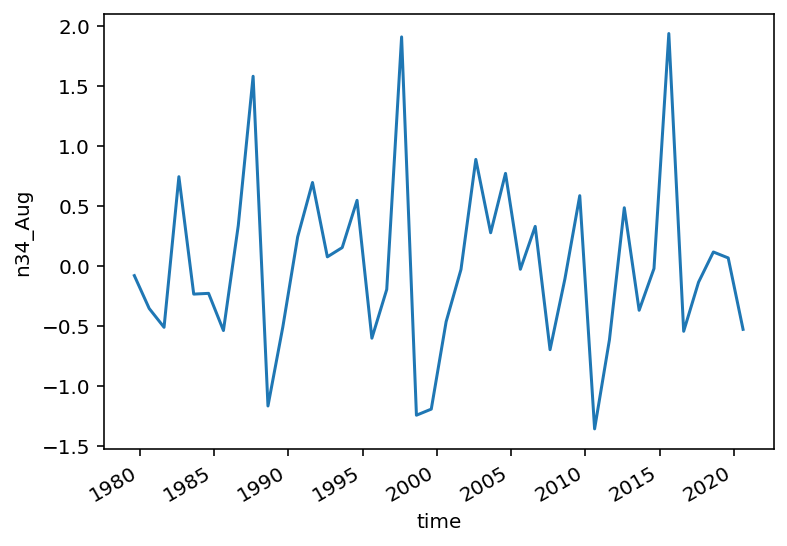

In [136]:
# Aug Nino 3.4 
n34_Aug_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_Aug/dods'
n34_Aug_ds = xr.open_dataset(n34_Aug_url)
n34_Aug = n34_Aug_ds.n34_Aug - n34_Aug_ds.n34_Aug.mean('T')
n34_Aug.plot();
K = 10
n34_Aug_1 = np.copy(n34_Aug)
n34_Aug_1[:]=n34_Aug_1[-1::-1]
n34_Aug_value = n34_Aug_1[0]
leave_1_out = list(range(1, len(n34_Aug_1)))
n34_Aug_1 = n34_Aug_1[leave_1_out]
n34_knn = np.argsort( (n34_Aug_1 - n34_Aug_value)**2)
knn = knn[:K]
knn_years = list(2021-knn)
print(knn_years)

/opt/conda/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


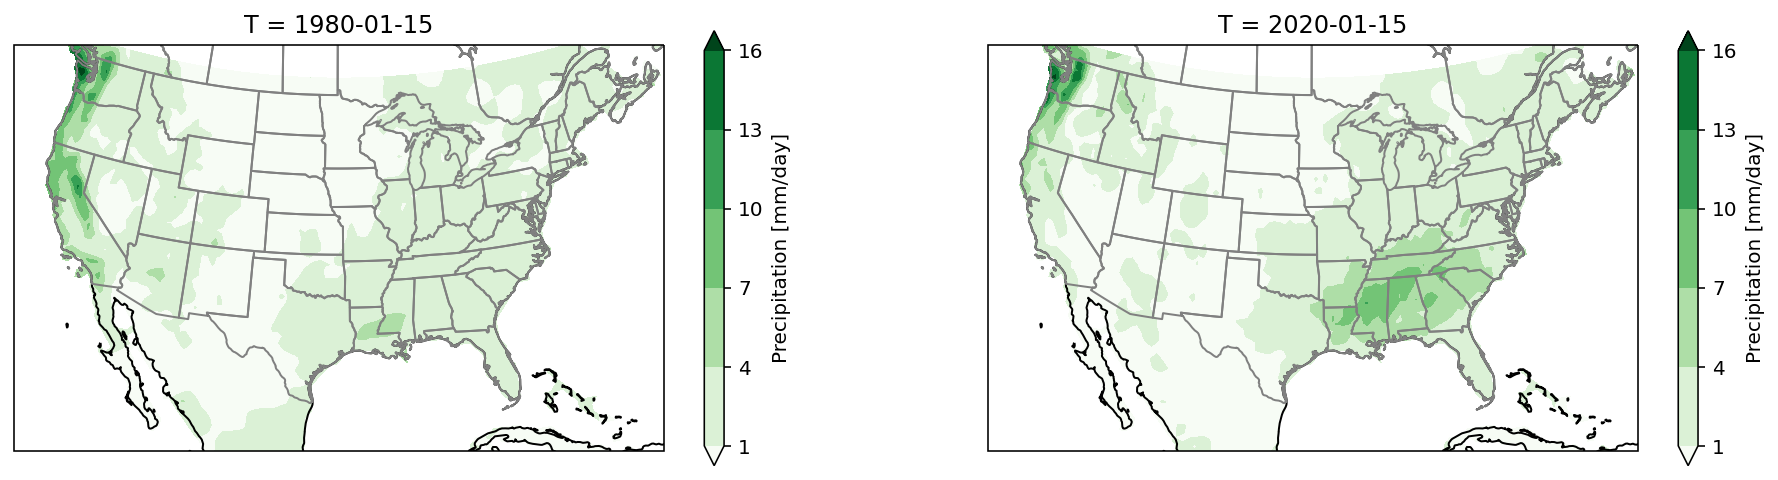

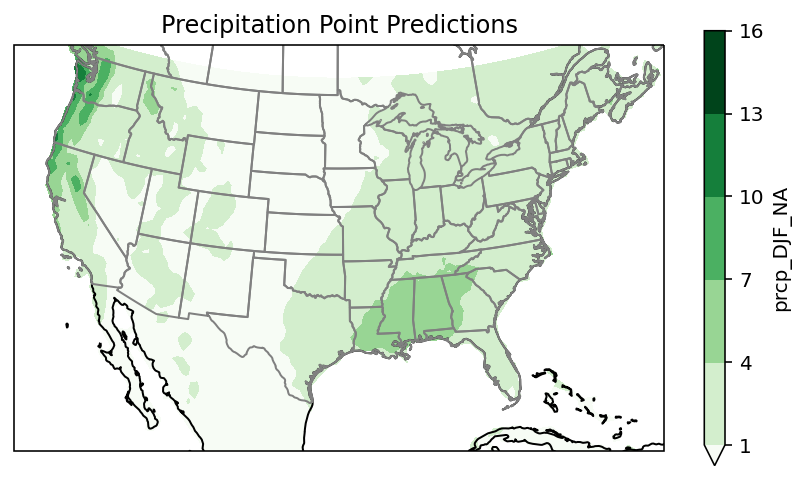

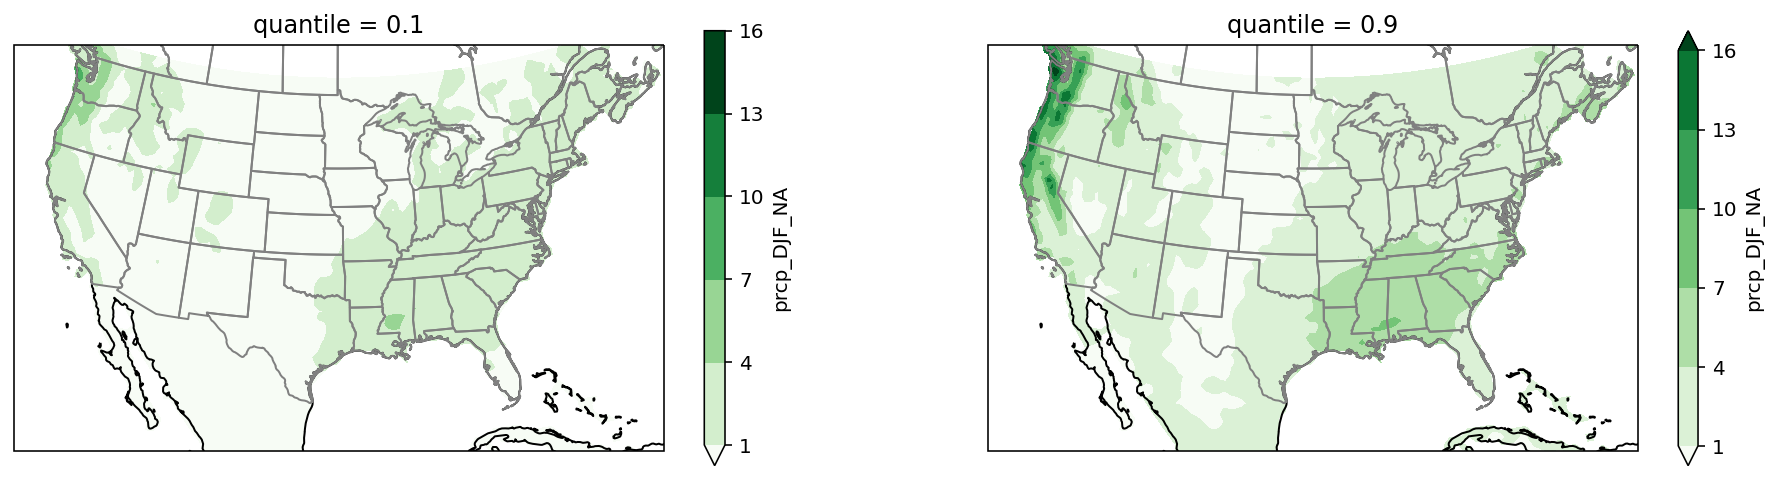

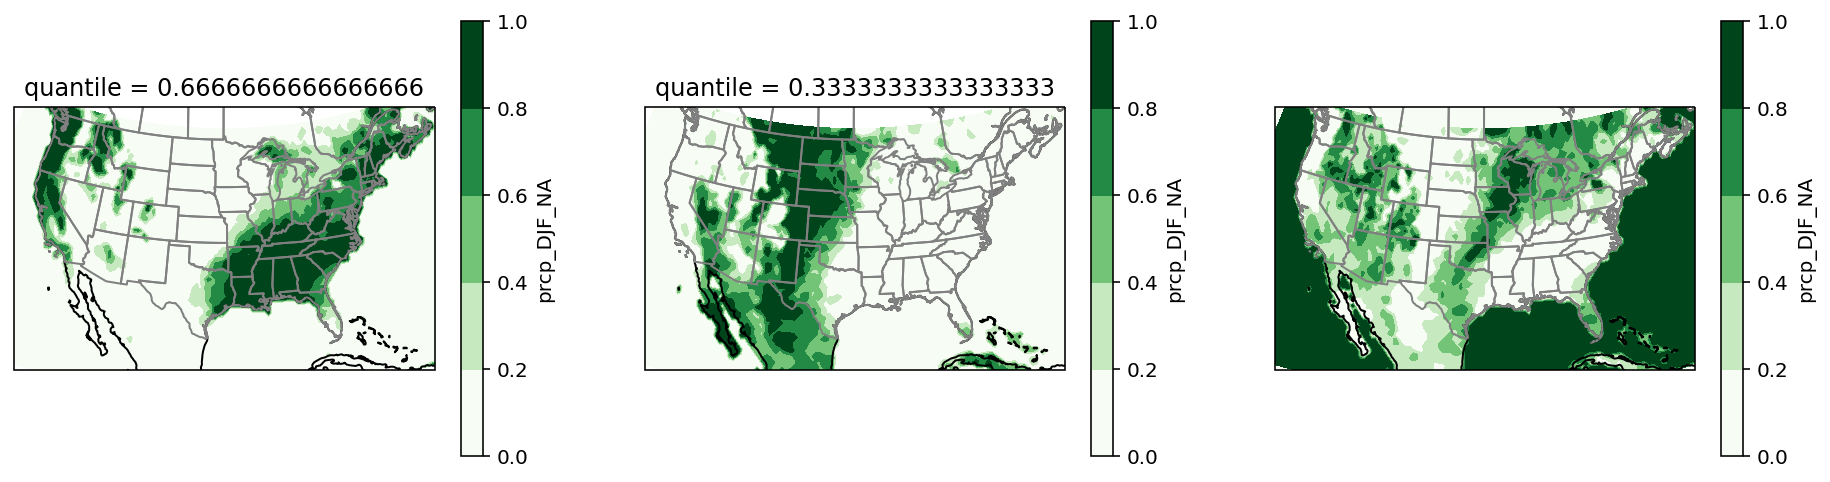

In [221]:
import matplotlib.colors as colors

prcp_DJF_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.prcp_DJF_NA/124/pop/dods'
prcp_DJF_ds = xr.open_dataset(prcp_DJF_url)
prcp = prcp_DJF_ds.prcp_DJF_NA
prcp.load()

prcp_forecast = xr.DataArray.mean(prcp[knn], dim = 'T')

prcp_80 = xr.DataArray.quantile(prcp[knn],[0.1,0.9], dim = 'T')
prcp_10 = prcp_80[0]
prcp_90 = prcp_80[1]

prcp_thresholds = xr.DataArray.quantile(prcp, np.array([1/3, 2/3]))
prcp_above = xr.DataArray.mean(prcp[knn] > prcp_thresholds[1], dim = 'T')
prcp_below = xr.DataArray.mean(prcp[knn] < prcp_thresholds[0], dim = 'T')
prcp_middle = 1 - (prcp_above + prcp_below)
#prcp_middle [np.isnan(prcp_above+prcp_below)] = np.nan? Want to get rid of 100% oceans somehow...

# two-panel plot of the first and last values 
# This is a "fancy" plot showing some additional features
proj_map = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(16,4))
ax1 = plt.subplot(1,2,1,projection=proj_map)
ax2 = plt.subplot(1,2,2,projection=proj_map)

extent = [-120, -70, 20, 50.5]

prcp.isel(T = 0).plot.contourf(transform=proj_dta, ax = ax1, vmin=1, vmax=16, cmap='Greens', levels = 6)
ax1.coastlines();
ax1.add_feature(cfeature.STATES, edgecolor='gray')
ax1.set_extent(extent)

prcp.isel(T =-1).plot.contourf(transform=proj_dta, ax = ax2, vmin=1, vmax=16, cmap='Greens', levels = 6);
ax2.coastlines();
ax2.add_feature(cfeature.STATES, edgecolor='gray')
ax2.set_extent(extent)

# Attempt at a second map
proj_map = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(16,4))
ax1 = plt.subplot(1,2,1,projection=proj_map)

extent = [-120, -70, 20, 50.5]

prcp_forecast.plot.contourf(transform=proj_dta, ax = ax1, vmin=1, vmax=16, cmap='Greens', levels = 6)
ax1.coastlines();
ax1.add_feature(cfeature.STATES, edgecolor='gray')
ax1.set_extent(extent)
ax1.set_title('Precipitation Point Predictions');

# Next pair of maps
proj_map = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(16,4))
ax1 = plt.subplot(1,2,1,projection=proj_map)
ax2 = plt.subplot(1,2,2,projection=proj_map)

extent = [-120, -70, 20, 50.5]

prcp_10.plot.contourf(transform=proj_dta, ax = ax1, vmin=1, vmax=16, cmap='Greens', levels = 6)
ax1.coastlines();
ax1.add_feature(cfeature.STATES, edgecolor='gray')
ax1.set_extent(extent)

prcp_90.plot.contourf(transform=proj_dta, ax = ax2, vmin=1, vmax=16, cmap='Greens', levels = 6);
ax2.coastlines();
ax2.add_feature(cfeature.STATES, edgecolor='gray')
ax2.set_extent(extent)

# Three this time!
proj_map = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(16,4))
ax1 = plt.subplot(1,3,1,projection=proj_map)
ax2 = plt.subplot(1,3,2,projection=proj_map)
ax3 = plt.subplot(1,3,3,projection=proj_map)

extent = [-120, -70, 20, 50.5]

prcp_above.plot.contourf(transform=proj_dta, ax = ax1, vmin=0, vmax=1, cmap='Greens', levels = 6)
ax1.coastlines();
ax1.add_feature(cfeature.STATES, edgecolor='gray')
ax1.set_extent(extent)

prcp_below.plot.contourf(transform=proj_dta, ax = ax2, vmin=0, vmax=1, cmap='Greens', levels = 6);
ax2.coastlines();
ax2.add_feature(cfeature.STATES, edgecolor='gray')
ax2.set_extent(extent)

prcp_middle.plot.contourf(transform=proj_dta, ax = ax3, vmin=0, vmax=1, cmap='Greens', levels = 6);
ax3.coastlines();
ax3.add_feature(cfeature.STATES, edgecolor='gray')
ax3.set_extent(extent)
